In [1]:
import findspark

findspark.init()
import pyspark

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
MAX_MEMORY = "7g"
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 30)
spark = SparkSession.builder.appName('Capstone Project V5').config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).config("spark.storage.memoryFraction",1.0).getOrCreate()


In [4]:
spark.catalog.clearCache()
orders= spark.read.csv(r"C:\Users\Owner\Downloads\order_sample.csv", header = True, inferSchema = True)
prior =spark.read.csv(r"D:\TN\Capstone\Datasets\order_products__prior.csv", header = True, inferSchema = True) 
train =spark.read.csv(r"D:\TN\Capstone\Datasets\order_products__train.csv", header = True, inferSchema = True) 
products = spark.read.csv(r"D:\TN\Capstone\Datasets\products.csv", header = True, inferSchema = True)
#orders.show(2)
#prior.show(2)
#train.show(2)
#products.show(2)

In [5]:
prior = prior.select('order_id','add_to_cart_order','reordered',prior.product_id.cast(StringType()).alias('product_id'))
train = train.select('order_id','add_to_cart_order','reordered',train.product_id.cast(StringType()).alias('product_id'))

In [6]:
orders.drop('eval_set')
#orders.show(2)
orders_prior_df = prior.join(orders, on = 'order_id', how = 'inner').drop('eval_set')
#orders_prior_df = orders_prior_df.where(orders_prior_df["reordered"]=1)
#orders_prior_df.show(2)
orders_train_df = train.join(orders, on = 'order_id', how = 'inner').drop('eval_set')
#orders_train_df.show(2)

In [7]:
#orders_prior_df.dtypes
#orders_train_df.dtypes

User_product features

In [8]:

from pyspark.sql.functions import col
from pyspark.sql.window import Window
column_list = ["user_id","product_id"]
window = Window.partitionBy([col(x) for x in column_list])

In [9]:
user_prod_df=orders_prior_df.select('user_id','product_id', F.round(F.avg('days_since_prior_order').over(window)).alias('user_prod_purchase_frequency'),F.count('order_id').over(window).alias('products_in_number_of_userorders'),F.sum('reordered').over(window).alias('number_of_times_prod_reordered'),F.round(F.avg('add_to_cart_order').over(window)).alias('avg_add_to_cart_order')).orderBy(orders_prior_df['user_id']).dropDuplicates()

In [10]:
#user_prod_df.show()

In [11]:
train_users = orders_train_df.select('user_id').dropDuplicates()

In [12]:
x_df = user_prod_df.join(train_users, on = 'user_id', how='inner')

In [13]:
x_df.show(5)

+-------+----------+----------------------------+--------------------------------+------------------------------+---------------------+
|user_id|product_id|user_prod_purchase_frequency|products_in_number_of_userorders|number_of_times_prod_reordered|avg_add_to_cart_order|
+-------+----------+----------------------------+--------------------------------+------------------------------+---------------------+
|    148|      1203|                        null|                               1|                             0|                 22.0|
|    148|      7870|                         3.0|                               2|                             1|                 25.0|
|    148|     18629|                         3.0|                               2|                             1|                  6.0|
|    148|      4025|                         1.0|                               1|                             0|                 15.0|
|    148|     22721|                        null

In [14]:

train_user_prod_df=orders_train_df.withColumn("list_of_products_in_latest_order", F.concat_ws(",", "product_id")).select("user_id", "days_since_prior_order","list_of_products_in_latest_order").groupBy("user_id").agg(F.collect_list("list_of_products_in_latest_order").alias("latest_ordered_products"))
train_user_prod_df_1 = orders_train_df.join(train_user_prod_df, on ='user_id', how = 'inner')
train_user_prod_df_2 = train_user_prod_df_1.select("user_id","latest_ordered_products","days_since_prior_order")


In [15]:
x_df=x_df.join(train_user_prod_df_2, on = 'user_id',how='inner')


In [16]:
from pyspark.sql.types import IntegerType

def in_cart(product_id,latest_ordered_products):
   # Check for the case where there is no Array, otherwise we will get an Error
   if latest_ordered_products == None:
      return None
   # Checking each and every Array element if it exists in 'FullAddress',
   # and if a match is found, it's immediately returned.
   for x in latest_ordered_products:
      if x in product_id:
         return 1
   return 0
simpleudf = udf(in_cart, IntegerType())
x_df=x_df.withColumn("is_in_next_cart",simpleudf(col('product_id'),col('latest_ordered_products')))


In [17]:
#x_df.orderBy("user_id").show()

In [18]:
from pyspark.sql.functions import dense_rank,col
window_1 = Window.partitionBy(orders_prior_df['user_id']).orderBy(orders_prior_df['order_number'].desc())
user_prod_latest4_df= orders_prior_df.withColumn('rank',dense_rank().over(window_1)).filter(col('rank')<=4).orderBy(orders_prior_df['user_id'])

In [19]:
#cols = ['user_id','order_number']
#user_prod_latest4_df.orderBy(*cols, ascending = True).show(50)

In [20]:

user_prod_last4orders = user_prod_latest4_df.select('user_id','product_id',F.round(F.avg('days_since_prior_order').over(window)).alias('user_prod_purchase_frequency_in_latest4orders'),F.count('order_id').over(window).alias('products_reordered_in_latest4orders')).dropDuplicates()

#user_prod_last4orders.orderBy('user_id', ascending = True).show()

In [21]:
x_df = x_df.join(user_prod_last4orders, on = ['user_id', 'product_id'], how = 'inner')

In [22]:
#x_df.show(2)


user_prod_last4orders = user_prod_latest4_df.select('user_id','product_id','order_id','rank',F.round(F.avg('days_since_prior_order').over(window)).alias('user_prod_purchase_frequency_in_latest4orders'),F.count('order_id').over(window).alias('products_reordered_in_latest4orders')).dropDuplicates()

user_prod_last4orders.orderBy('user_id', ascending = True).show()

In [23]:
user_prod_latest4_2 = user_prod_latest4_df.withColumn("products", F.concat_ws(",", "product_id")).select("order_id","user_id", "order_number",'products').groupBy("order_id").agg(F.collect_list("products").alias("products"))
#user_prod_latest4_2.show(5)

In [24]:
user_prod_latest4_df = user_prod_latest4_df.join(user_prod_latest4_2, on = 'order_id', how = 'inner')


In [25]:
#user_prod_latest4_df.show()

In [26]:
latest_prod = user_prod_latest4_df.select("user_id","products").where(user_prod_latest4_df["rank"] == 1).dropDuplicates()
latest_prod = latest_prod.withColumnRenamed("products","latest1_products")
latest1_prod = user_prod_latest4_df.select("user_id","products").where(user_prod_latest4_df["rank"] == 2).dropDuplicates()
latest1_prod = latest1_prod.withColumnRenamed("products","latest2_products")

In [27]:
#latest_prod.show(2)
#latest1_prod.show(2)

user_prod_latest4 = user_prod_latest4orders.select("user_id","product_id","user_prod_purchase_frequency_in_latest4orders","products_reordered_in_latest4orders")
user_prod_latest4.dtypes

In [28]:
x_df = x_df.join(latest_prod, on = 'user_id', how = 'inner')
x_df = x_df.join(latest1_prod, on = 'user_id', how = 'inner')
#x_df.show(2)


In [29]:
x_df=x_df.withColumn("is_in_latest1_order",simpleudf(col('product_id'),col('latest1_products')))
x_df.dtypes

[('user_id', 'int'),
 ('product_id', 'string'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('is_in_latest1_order', 'int')]

In [30]:
#x_df.show(2)

In [31]:
x_df=x_df.withColumn("is_in_latest2_order",simpleudf(col('product_id'),col('latest2_products')))
x_df.dtypes

[('user_id', 'int'),
 ('product_id', 'string'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int')]

#x_df.cache()

x_df.orderBy(['user_id','product_id'],ascending = True).show()

In [32]:
#User features
window2 = Window.partitionBy(orders_prior_df['user_id'])
user_df = orders_prior_df.select('order_id','user_id','product_id',F.round(F.avg('days_since_prior_order').over(window2)).alias("User_purchase_frequency"),F.max('order_number').over(window2).alias("User_total_orders"))
user_df_1 = user_df.groupBy('user_id').agg(F.countDistinct('product_id').alias('user_total_products'))
user_df_2 = user_df.groupBy(['user_id','order_id']).agg(F.count('product_id').alias('product_count'))
user_df_3 = user_df_2.groupBy('user_id').agg(F.round(F.avg('product_count')).alias('avg_cart_size')).dropDuplicates()

#user_df_3.orderBy('user_id').show()

In [33]:
userdf = user_df.join(user_df_1, on = 'user_id', how = 'inner')
#userdf.show(2)

In [34]:
userdf = userdf.join(user_df_3, on ='user_id', how = 'inner').dropDuplicates()

In [35]:
userdf=userdf.drop('order_id','product_id').dropDuplicates()

#userdf.orderBy('user_id').show()

In [36]:
x_df = x_df.join(userdf, on = 'user_id', how = 'inner')
x_df.dtypes

[('user_id', 'int'),
 ('product_id', 'string'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double')]

In [37]:
#Product features
window3 = Window.partitionBy(orders_prior_df['product_id'])
product_df = orders_prior_df.select('product_id',F.round(F.avg('days_since_prior_order').over(window3)).alias("products_purchase_frequency"),F.count('order_id').over(window3).alias("NumberOfTimes_product_ordered")).dropDuplicates()
#product_df.orderBy('product_id').show(5)
#number of users' ordered the product

In [38]:
x_df = x_df.join(product_df, on = 'product_id', how = 'inner')


x_df.orderBy('user_id').show(10)

In [39]:
x_df=x_df.drop('latest_ordered_products','latest1_products','latest2_products')
x_df.dtypes


[('product_id', 'string'),
 ('user_id', 'int'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double'),
 ('products_purchase_frequency', 'double'),
 ('NumberOfTimes_product_ordered', 'bigint')]

In [40]:

x_df = x_df.withColumn("User_prod_reorder_rate", x_df["products_in_number_of_userorders"]/x_df["user_total_orders"])


In [41]:
#x_df.show(2)

In [42]:
x_df.dtypes

[('product_id', 'string'),
 ('user_id', 'int'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double'),
 ('products_purchase_frequency', 'double'),
 ('NumberOfTimes_product_ordered', 'bigint'),
 ('User_prod_reorder_rate', 'double')]

In [43]:
x_df=x_df.withColumn("productid", x_df.product_id.cast("int"))


In [44]:
x_df.dtypes

[('product_id', 'string'),
 ('user_id', 'int'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double'),
 ('products_purchase_frequency', 'double'),
 ('NumberOfTimes_product_ordered', 'bigint'),
 ('User_prod_reorder_rate', 'double'),
 ('productid', 'int')]

In [45]:
x_df = x_df.drop('product_id')
x_df = x_df.withColumnRenamed("productid","product_id")
x_df.dtypes

[('user_id', 'int'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('days_since_prior_order', 'int'),
 ('is_in_next_cart', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double'),
 ('products_purchase_frequency', 'double'),
 ('NumberOfTimes_product_ordered', 'bigint'),
 ('User_prod_reorder_rate', 'double'),
 ('product_id', 'int')]

x_df.write.csv('instacart_feature.csv',header = True)

In [46]:
#print(x_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in x_df.columns]).toPandas().transpose())
x_df = x_df.na.fill(999)
print(x_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in x_df.columns]).toPandas().transpose())

                                               0
user_id                                        0
user_prod_purchase_frequency                   0
products_in_number_of_userorders               0
number_of_times_prod_reordered                 0
avg_add_to_cart_order                          0
days_since_prior_order                         0
is_in_next_cart                                0
user_prod_purchase_frequency_in_latest4orders  0
products_reordered_in_latest4orders            0
is_in_latest1_order                            0
is_in_latest2_order                            0
User_purchase_frequency                        0
User_total_orders                              0
user_total_products                            0
avg_cart_size                                  0
products_purchase_frequency                    0
NumberOfTimes_product_ordered                  0
User_prod_reorder_rate                         0
product_id                                     0


In [47]:

#target column identification
target_col = x_df["is_in_next_cart"]
print("Target column is ",target_col)
drptar = x_df.drop("is_in_next_cart")

Target column is  Column<b'is_in_next_cart'>


In [48]:
#x_df.show(5)
#drptar.show(5)

In [49]:
drptar.dtypes

[('user_id', 'int'),
 ('user_prod_purchase_frequency', 'double'),
 ('products_in_number_of_userorders', 'bigint'),
 ('number_of_times_prod_reordered', 'bigint'),
 ('avg_add_to_cart_order', 'double'),
 ('days_since_prior_order', 'int'),
 ('user_prod_purchase_frequency_in_latest4orders', 'double'),
 ('products_reordered_in_latest4orders', 'bigint'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('User_purchase_frequency', 'double'),
 ('User_total_orders', 'int'),
 ('user_total_products', 'bigint'),
 ('avg_cart_size', 'double'),
 ('products_purchase_frequency', 'double'),
 ('NumberOfTimes_product_ordered', 'bigint'),
 ('User_prod_reorder_rate', 'double'),
 ('product_id', 'int')]

In [50]:
num_cols = [t[0] for t in drptar.dtypes if t[1] == 'int' or t[1] == 'double' or t[1]=='bigint']
#num_cols = df._get_numeric_data().columns
print("numerical columns: ",num_cols)
cat_cols = [t[0] for t in drptar.dtypes if t[1] == 'string']
print("categorical columns: ",cat_cols)

numerical columns:  ['user_id', 'user_prod_purchase_frequency', 'products_in_number_of_userorders', 'number_of_times_prod_reordered', 'avg_add_to_cart_order', 'days_since_prior_order', 'user_prod_purchase_frequency_in_latest4orders', 'products_reordered_in_latest4orders', 'is_in_latest1_order', 'is_in_latest2_order', 'User_purchase_frequency', 'User_total_orders', 'user_total_products', 'avg_cart_size', 'products_purchase_frequency', 'NumberOfTimes_product_ordered', 'User_prod_reorder_rate', 'product_id']
categorical columns:  []


In [51]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import OneHotEncoderEstimator
categoricalColumns = cat_cols
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'is_in_next_cart', outputCol = 'label')
stages += [label_stringIdx]
#numericCols = ['tenure', 'MonthlyCharges', 'TotalCharges']
numericCols = num_cols
assemblerInputs = [a + "classVec" for a in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [52]:

columns = x_df.columns
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(x_df)
df = pipelineModel.transform(x_df)
selectedCols = ['label', 'features'] + columns
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_prod_purchase_frequency: double (nullable = false)
 |-- products_in_number_of_userorders: long (nullable = false)
 |-- number_of_times_prod_reordered: long (nullable = true)
 |-- avg_add_to_cart_order: double (nullable = false)
 |-- days_since_prior_order: integer (nullable = true)
 |-- is_in_next_cart: integer (nullable = true)
 |-- user_prod_purchase_frequency_in_latest4orders: double (nullable = false)
 |-- products_reordered_in_latest4orders: long (nullable = false)
 |-- is_in_latest1_order: integer (nullable = true)
 |-- is_in_latest2_order: integer (nullable = true)
 |-- User_purchase_frequency: double (nullable = false)
 |-- User_total_orders: integer (nullable = true)
 |-- user_total_products: long (nullable = false)
 |-- avg_cart_size: double (nullable = false)
 |-- products_purchase_frequency: double (nullable = false)
 |-- NumberOfTimes_product

In [53]:
df = df.select('label','features','user_id','product_id','days_since_prior_order')

df.cache()
df.show(2)

In [54]:
users = df.select('user_id').distinct()
users.orderBy('user_id').show(5)

+-------+
|user_id|
+-------+
|      1|
|      2|
|      5|
|      7|
|      8|
+-------+
only showing top 5 rows



In [55]:
test_users = users.sample(False, 0.2, 42)
test_users.orderBy('user_id').show()

+-------+
|user_id|
+-------+
|     23|
|     29|
|     34|
|     42|
|     47|
|     64|
|     67|
|     70|
|     79|
|     84|
|     97|
|    114|
|    117|
|    120|
|    155|
|    161|
|    176|
|    193|
|    198|
|    203|
+-------+
only showing top 20 rows



In [56]:
user_list = list(test_users.select('user_id').toPandas()['user_id'])

In [57]:
test = df.where(df["user_id"].isin (user_list))
test.dtypes



[('label', 'double'),
 ('features', 'vector'),
 ('user_id', 'int'),
 ('product_id', 'int'),
 ('days_since_prior_order', 'int')]

In [58]:
train = df.where(~df["user_id"].isin (user_list))
train.dtypes

[('label', 'double'),
 ('features', 'vector'),
 ('user_id', 'int'),
 ('product_id', 'int'),
 ('days_since_prior_order', 'int')]

In [59]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
RFmodel = rf.fit(train)
predictions = RFmodel.transform(test)
Train_predictions = RFmodel.transform(train)
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderPR')
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions, {evaluator.metricName: "areaUnderROC"})))
print("Test Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
predictions_pandas = predictions.toPandas() 
print('Test Area Under PR: ', evaluator.evaluate(predictions))



Training accuracy: 0.7466957565916846
Test Accuracy: 0.7470932128962567
Test Area Under PR:  0.4810912193009412


In [60]:
from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction) 
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction) 
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)
print('F1-Score: {}, Recall: {}, Precision: {}'.format(f1, recall, precision))

F1-Score: 0.3571837090996659, Recall: 0.25148000056515535, Precision: 0.6161808488541162


print("Not buy: ",train.filter(train['label']==0).count())
print("Buy: ",train.filter(train['label']==1).count())

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [61]:
spark.catalog.clearCache()
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = 10)
# Train model with Training Data
LRmodel = LR.fit(train)


FPR:  0      0.000000
1      0.001169
2      0.002560
3      0.003892
4      0.006659
         ...   
197    0.983383
198    0.988416
199    0.993633
200    1.000000
201    1.000000
Name: FPR, Length: 202, dtype: float64
TPR:  0      0.000000
1      0.016326
2      0.035703
3      0.051370
4      0.073623
         ...   
197    0.997001
198    0.998434
199    0.999178
200    1.000000
201    1.000000
Name: TPR, Length: 202, dtype: float64


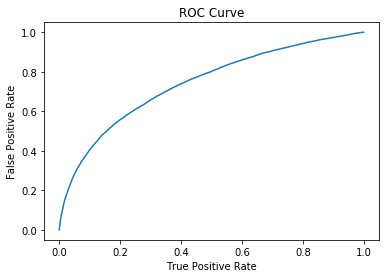

Training accuracy: 0.7417531193122249


In [62]:
#Summarizing model on training data and obtaining the receiver-operating characteristic and areaUnderROC.
trainingSummary = LRmodel.summary
roc = trainingSummary.roc.toPandas()
print('FPR: ',roc['FPR'])
print('TPR: ',roc['TPR'])
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training accuracy: ' + str(trainingSummary.areaUnderROC))


precision:  0      0.802556
1      0.802556
2      0.802322
3      0.793415
4      0.762880
         ...   
196    0.228614
197    0.227805
198    0.227160
199    0.226367
200    0.225394
Name: precision, Length: 201, dtype: float64
recall : 0      0.000000
1      0.016326
2      0.035703
3      0.051370
4      0.073623
         ...   
196    0.995688
197    0.997001
198    0.998434
199    0.999178
200    1.000000
Name: recall, Length: 201, dtype: float64


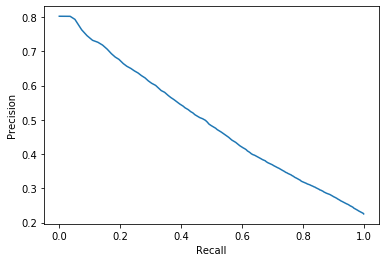

In [63]:
#Precision and recall.

pr = trainingSummary.pr.toPandas()
print('precision: ',pr['precision'])
print('recall :' ,pr['recall'])
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [64]:
fMeasure = trainingSummary.fMeasureByThreshold
print('fMeasure: ',fMeasure)
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
LR = LR.setThreshold(bestThreshold)
LRmodel = LR.fit(train)


fMeasure:  DataFrame[threshold: double, F-Measure: double]


In [65]:
print('Max fmeasure: ',maxFMeasure)

Max fmeasure:  Row(max(F-Measure)=0.4970603474174452)


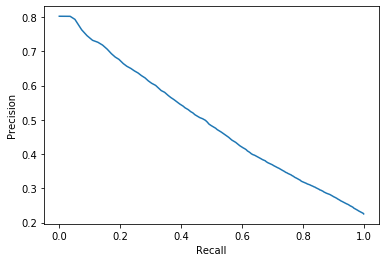

In [66]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [67]:
predictions = LRmodel.transform(test)
Train_predictions = LRmodel.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Training accuracy: ' + str(evaluator.evaluate(Train_predictions)))
print("Test Accuracy: " + str(evaluator.evaluate(predictions)))


Training accuracy: 0.7417693496894918
Test Accuracy: 0.744014830361391
